Out of date

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from datetime import datetime
try:
    import winsound
except:
    print("No beep")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [2]:
# Utility functions
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be changed.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def start_timer():
    global start_time
    start_time = datetime.now()
    print('Start time: ', start_time.strftime('%H:%M:%S'))

def end_timer():
    end_time = datetime.now()
    print('End time: ', end_time.strftime('%H:%M:%S'))
    runtime = end_time - start_time
    print('Runtime: ', runtime,'\n')

def beep_when_done():
    duration = 300  # milliseconds
    freq = 440  # Hz
    try:
        winsound.Beep(freq, duration)
    except:
        print("Beep! (Sound not working)")


In [3]:
# For default models
def fit_eval(clf, name, normalize=True):
    pipe = Pipeline([("prep", preprocess), ("model", clf)])

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipe.fit(X_tr, y_tr)

    y_pred = pipe.predict(X_te)

    print(f"\n=== {name} : classification_report (default threshold) ===")
    print(metrics.classification_report(y_te, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_te, y_pred)
    plot_confusion_matrix(cm, ['No diabetes', 'Diabetes'], normalize)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_te)[:, 1] 
        roc = metrics.roc_auc_score(y_te, y_proba)
        pr  = metrics.average_precision_score(y_te, y_proba) 
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(X_te)
        roc = metrics.roc_auc_score(y_te, scores)
        pr  = metrics.average_precision_score(y_te, scores)
    else:
        roc = pr = None

    if roc is not None:
        print(f"ROC-AUC: {roc:.3f}")
        print(f"PR-AUC : {pr:.3f}")

    # Optional: return items for programmatic use (e.g., to compare across models)
    # return {
    #     "name": name,
    #     "estimator": pipe,
    #     "y_true": y_te,
    #     "y_pred": y_pred,
    #     "roc_auc": roc,
    #     "pr_auc": pr,
    #     "confusion_matrix": cm
    # }

In [4]:
# For tuned models
def eval_pipeline(pipe, name, normalize_cm=True):
    # Hard predictions at the model's default threshold 0.5
    y_pred = pipe.predict(X_te)

    print(f"\n=== {name} (best params) ===")
    print(metrics.classification_report(y_te, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_te, y_pred)
    print("Confusion matrix (counts):\n", cm)

    plot_confusion_matrix(cm, ['No diabetes','Diabetes'], normalize_cm)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        scores = pipe.predict_proba(X_te)[:, 1]  
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(X_te) 
    else:
        print("Estimator has neither predict_proba nor decision_function; skipping AUCs.")
        return

    print(f"ROC-AUC: {metrics.roc_auc_score(y_te, scores):.3f}")
    print(f"PR-AUC : {metrics.average_precision_score(y_te, scores):.3f}")

    # Optional: return values for programmatic comparison
    # return {
    #     "name": name,
    #     "y_true": y_te,
    #     "y_pred": y_pred,
    #     "confusion_matrix": cm,
    #     "roc_auc": metrics.roc_auc_score(y_te, scores),
    #     "pr_auc": metrics.average_precision_score(y_te, scores),
    # }

In [5]:
data1_filename = "diabetes_binary_health_indicators_BRFSS2015.csv"
df1 = pd.read_csv(data1_filename)

# Taken from datacard on Kaggle, augmented by descriptions given in primary source.

column_descriptions = {
    'Diabetes_012':"0 = no diabetes 1 = diabetes",
     'HighBP':"0 = no high BP 1 = high BP",
     'HighChol':"0 = no high cholesterol 1 = high cholesterol",
     'CholCheck':"0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years",
     'BMI':"Body Mass Index",
     'Smoker':"Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes",
     'Stroke':"(Ever told) you had a stroke. 0 = no 1 = yes",
     'HeartDiseaseorAttack':"coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes",
     'PhysActivity':"physical activity in past 30 days - not including job 0 = no 1 = yes",
     'Fruits':"Consume Fruit 1 or more times per day 0 = no 1 = yes ",
     'Veggies':"Consume Vegetables 1 or more times per day 0 = no 1 = yes",
     'HvyAlcoholConsump':"Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no",
     'AnyHealthcare':"Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes",
     'NoDocbcCost':"Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes",
     'GenHlth':"Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor",
     'MentHlth':"Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days",
     'PhysHlth':"Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days",
     'DiffWalk':"Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes",
     'Sex':"0 = female 1 = male",
     'Age':"13-level age category (_AGEG5YR see codebook) 1 = 18-24, 2 = 25-29, 3 = 30-34, etc, 9 = 60-64, 13 = 80 or older",
     'Education':"Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)",
     'Income':"Income scale (INCOME2 see codebook) scale 1-8. 1 = less than $10k, 2 = less than $15k, 3 = less than $20k, 4 = less than $25k, 5 = less than $35k, 6 = less than $50k, 7 = less than $75k, 8 = $75k or more"
}

In [6]:
# df1.info()

In [7]:
# df1.head()

In [8]:
# df1.nunique()

In [9]:
y = df1["Diabetes_binary"].astype(int)
X = df1.drop(columns=["Diabetes_binary"])

binary_cols = [c for c in X.columns if set(pd.unique(X[c].dropna())) <= {0, 1}]
numeric_cols = [c for c in X.columns if c not in binary_cols]

for c in binary_cols:
    X[c] = X[c].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# ---- Scoring choice (very important) ----

fbeta = metrics.make_scorer(metrics.fbeta_score, beta=2.0)

# scoring = "recall"
scoring = fbeta



=== Logistic Regression : classification_report (default threshold) ===
              precision    recall  f1-score   support

           0      0.949     0.727     0.823     43667
           1      0.311     0.761     0.441      7069

    accuracy                          0.732     50736
   macro avg      0.630     0.744     0.632     50736
weighted avg      0.860     0.732     0.770     50736



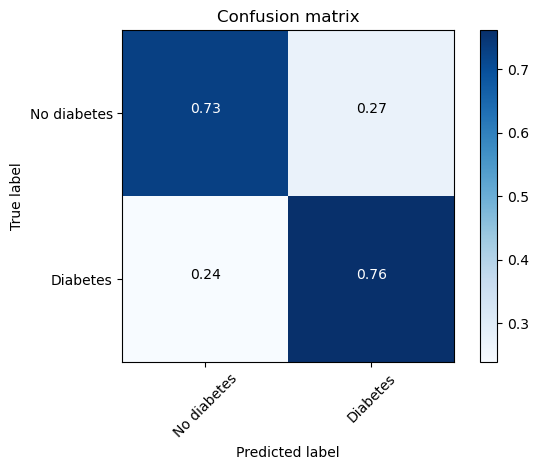

ROC-AUC: 0.820
PR-AUC : 0.393


In [11]:
# Fixed model parameters
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000
)


fit_eval(logreg, "Logistic Regression")

Start time:  12:44:32
LogReg best CV score [fbeta_score]: 0.593
LogReg best params: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': np.float64(10.0)}

=== Logistic Regression (tuned) (best params) ===
              precision    recall  f1-score   support

           0      0.949     0.727     0.823     43667
           1      0.311     0.761     0.441      7069

    accuracy                          0.732     50736
   macro avg      0.630     0.744     0.632     50736
weighted avg      0.860     0.732     0.770     50736

Confusion matrix (counts):
 [[31737 11930]
 [ 1689  5380]]


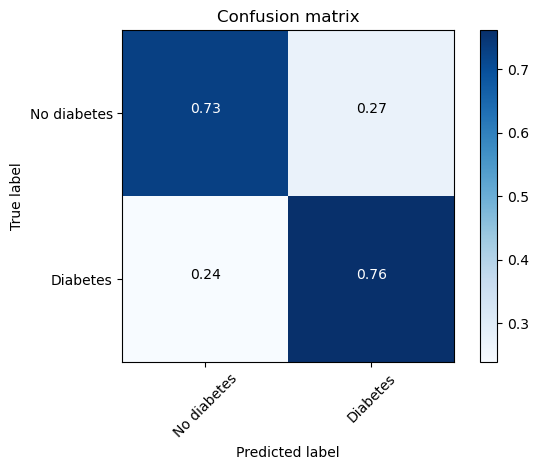

ROC-AUC: 0.820
PR-AUC : 0.393
End time:  12:49:17
Runtime:  0:04:45.151291 



In [12]:
# ---------- 1) Logistic Regression: RandomizedSearchCV ----------

start_timer()

logreg_base = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

log_C = list(np.logspace(-3, 1, 20))

logreg_param_distributions = [
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": log_C,
        "model__class_weight": ["balanced"]
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["l1", "l2"],     
        "model__C": log_C,
        "model__class_weight": ["balanced"]
    }
]

logreg_rs = RandomizedSearchCV(
    estimator=logreg_base,
    param_distributions=logreg_param_distributions,
    n_iter=40,            
    scoring=scoring, 
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=0
)


logreg_rs.fit(X_tr, y_tr)


label = (scoring if isinstance(scoring, str)
         else (sgd_rs.refit if isinstance(scoring, dict)
               else getattr(scoring, "_score_func", scoring).__name__))
print(f"LogReg best CV score [{label}]: {logreg_rs.best_score_:.3f}")
print("LogReg best params:", logreg_rs.best_params_)

eval_pipeline(logreg_rs.best_estimator_, "Logistic Regression (tuned)")

end_timer()
beep_when_done()



=== SGDClassifier : classification_report (default threshold) ===
              precision    recall  f1-score   support

           0      0.938     0.756     0.837     43667
           1      0.315     0.694     0.434      7069

    accuracy                          0.747     50736
   macro avg      0.627     0.725     0.636     50736
weighted avg      0.852     0.747     0.781     50736



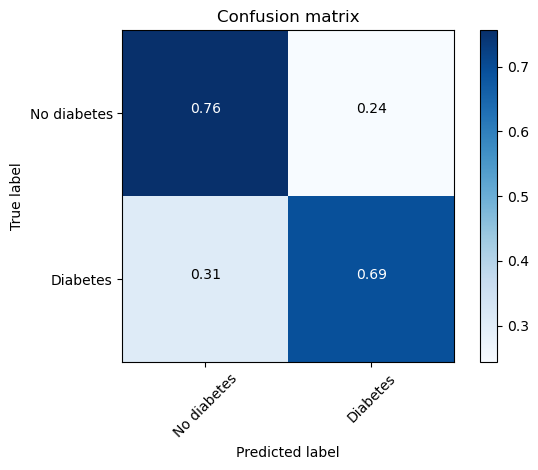

ROC-AUC: 0.803
PR-AUC : 0.366


In [13]:
# Fixed model parameters

SGDClass = SGDClassifier(
    loss="log_loss",          
    class_weight="balanced",
    max_iter=5000,
    tol=1e-4,
    alpha=1e-5,                
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    random_state=42
)

fit_eval(SGDClass, "SGDClassifier")

Start time:  12:49:18
SGD best CV score [fbeta_score]: 0.585
SGD best params: {'model__validation_fraction': 0.2, 'model__tol': 0.0001, 'model__penalty': 'l1', 'model__n_iter_no_change': 10, 'model__max_iter': 4000, 'model__loss': 'hinge', 'model__l1_ratio': 0.15, 'model__early_stopping': True, 'model__class_weight': 'balanced', 'model__alpha': 0.0001}

=== SGDClassifier (tuned) (best params) ===
              precision    recall  f1-score   support

           0      0.956     0.675     0.791     43667
           1      0.287     0.806     0.423      7069

    accuracy                          0.693     50736
   macro avg      0.621     0.741     0.607     50736
weighted avg      0.862     0.693     0.740     50736

Confusion matrix (counts):
 [[29487 14180]
 [ 1372  5697]]


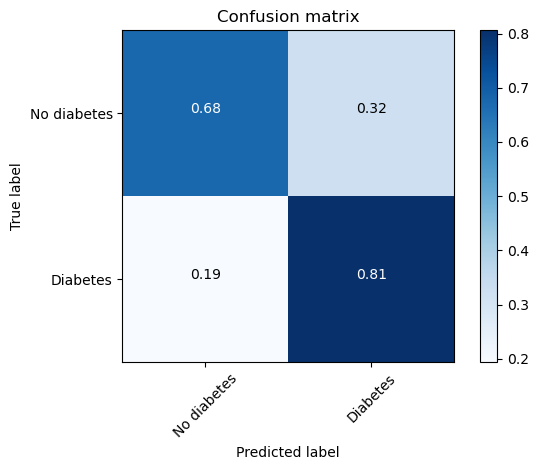

ROC-AUC: 0.811
PR-AUC : 0.377
End time:  12:49:51
Runtime:  0:00:33.194266 



In [14]:
# ---------- 2) SGDClassifier: RandomizedSearchCV  ----------

start_timer()

sgd_base = Pipeline([
    ("prep", preprocess),
    ("model", SGDClassifier(random_state=42))
])

sgd_param_dist = {
    "model__loss": ["log_loss", "modified_huber", "hinge"],
    "model__alpha": [1e-6, 3e-6, 1e-5, 3e-5, 1e-4],
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__l1_ratio": [0.0, 0.15, 0.5, 0.9],  # only used when penalty='elasticnet'
    "model__max_iter": [2000, 4000, 6000],
    "model__tol": [1e-4, 1e-3],
    "model__class_weight": ["balanced"],
    "model__early_stopping": [True],          # lets SGD pick iterations automatically
    "model__validation_fraction": [0.1, 0.15, 0.2],
    "model__n_iter_no_change": [5, 10, 15],
}

sgd_rs = RandomizedSearchCV(
    estimator=sgd_base,
    param_distributions=sgd_param_dist,
    n_iter=40,
    scoring=scoring, 
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=0
)

sgd_rs.fit(X_tr, y_tr)

label = (scoring if isinstance(scoring, str)
         else (sgd_rs.refit if isinstance(scoring, dict)
               else getattr(scoring, "_score_func", scoring).__name__))
print(f"SGD best CV score [{label}]: {sgd_rs.best_score_:.3f}")

print("SGD best params:", sgd_rs.best_params_)

eval_pipeline(sgd_rs.best_estimator_, "SGDClassifier (tuned)")

end_timer()
beep_when_done()
